# Курсовой проект

## Задание

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

##### Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

#### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма , которую предстоит еще выплатить)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг (ежемесячная сумма к выплате)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка библиотек

In [5674]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import random

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import random

import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [5675]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [5676]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5677]:
df_train.shape

(7500, 17)

In [5678]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5679]:
df_test.shape

(2500, 16)

In [5680]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Оптимизация занимаемой памяти

In [5681]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df


In [5682]:
#df_train = optimizing_df(df_train)
#df_test = optimizing_df(df_test)

#Переносим в конец

In [5683]:
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = GradientBoostingRegressor(n_estimators=110,
                                  max_depth=8,
                                  random_state=42,
                                  loss='huber',
                                  learning_rate=0.2)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    pred = model.predict(predict_data.drop(columns=target_col))
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

### Типы данных

In [5684]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## Изучение признаков -  Feature Exploring  

#### Выделение признакового описания и целевой переменной

In [5685]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies', 'Months since last delinquent',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership', 'Years in current job', 
                    'Purpose', 'Term' ]

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Credit Score', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt', 'Bankruptcies']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Целевая переменная - Credit Default

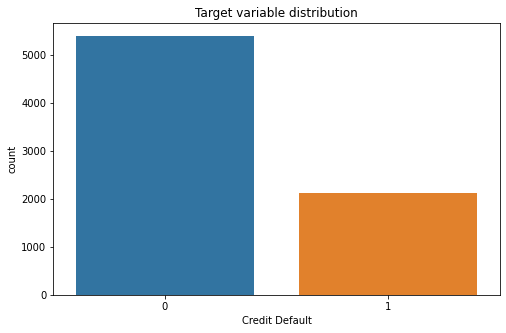

In [5686]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [5687]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Очевидна разбалансировка классов, которую необходимо будет выровнять**

In [5688]:
df_train['Purpose'].dtype

dtype('O')

### Матрица корреляций

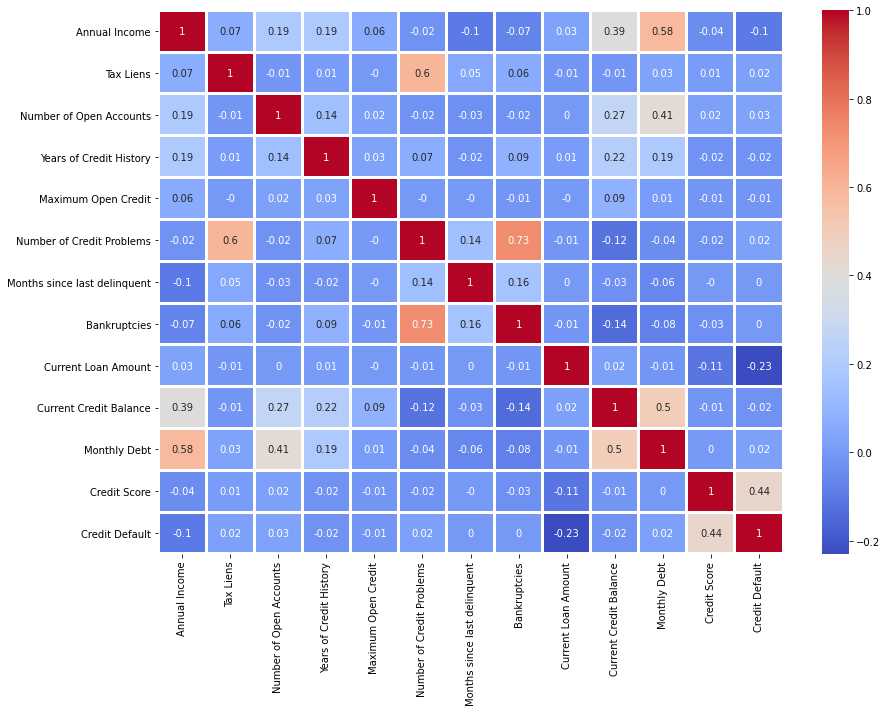

In [5689]:
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix,2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot=True, linewidth = 2, cmap = 'coolwarm')
plt.show()

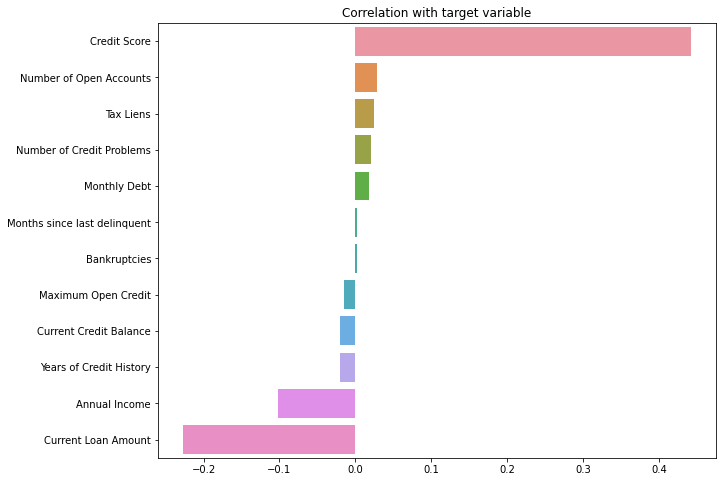

In [5690]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

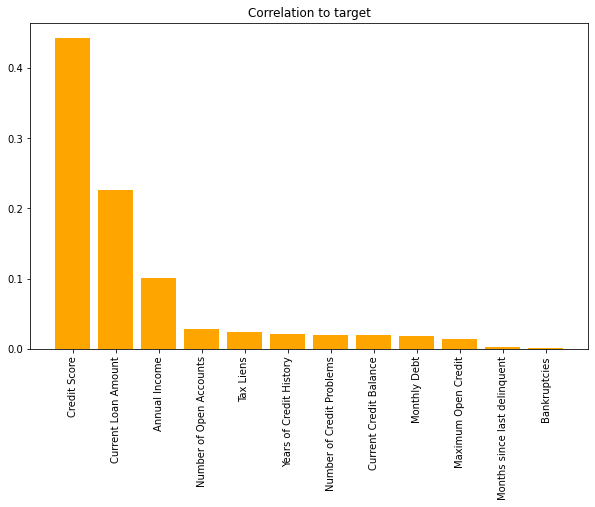

In [5691]:
corr_matrix = df_train.corrwith(df_train['Credit Default'])
corr_matrix = df_train.loc[:, df_train.columns != 'Credit Default'].corrwith(df_train['Credit Default']).abs().sort_values(ascending=False)
plt.figure(figsize = (10, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'orange')
plt.title('Correlation to target')
plt.xticks(rotation='vertical')
plt.show()

### Изучение  признаков

In [5692]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [5693]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Признаки, содержащие пропуски - **Annual Income, Months since last delinquent, Years in current job, Bankruptcies, Credit Score**

### Вещественные признаки

Annual Income


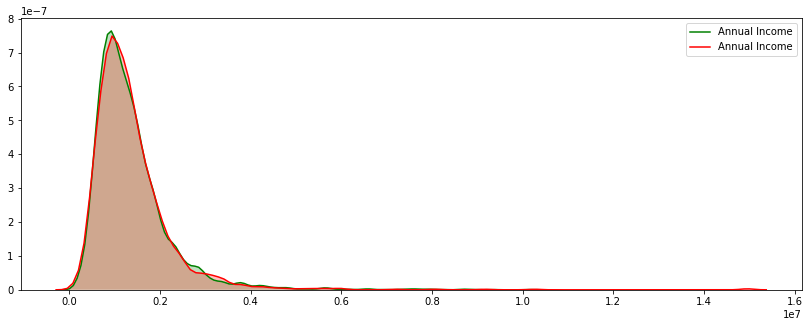

Tax Liens


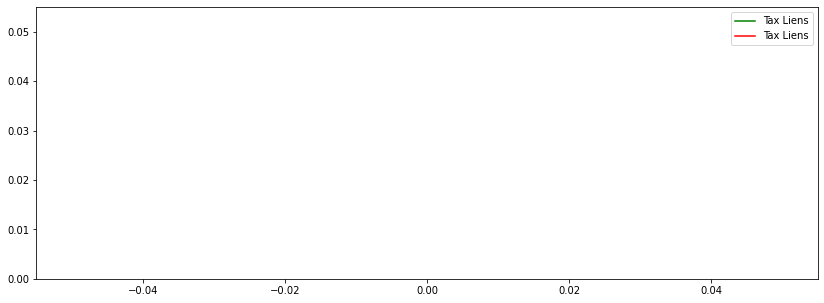

Number of Open Accounts


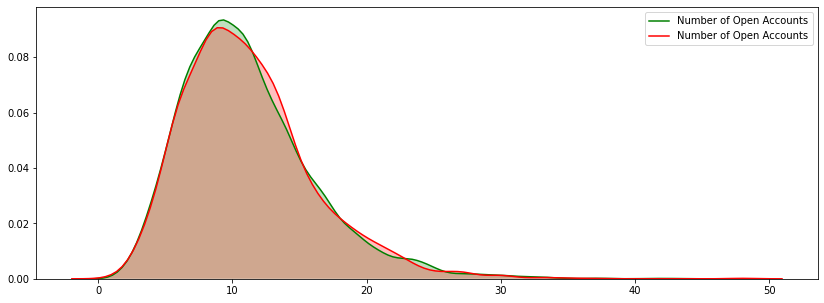

Years of Credit History


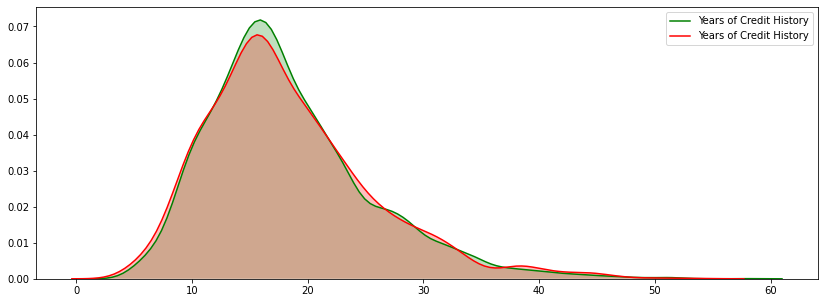

Maximum Open Credit


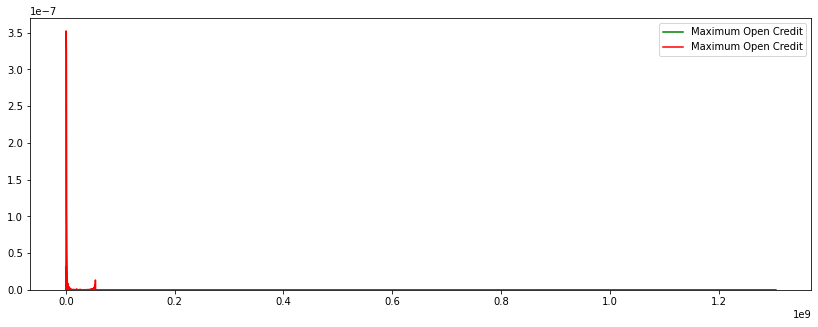

Number of Credit Problems


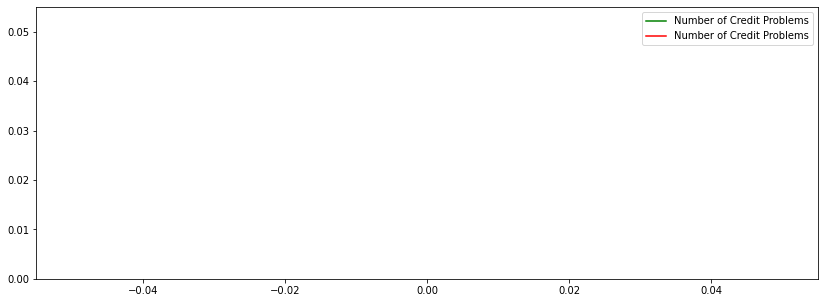

Current Loan Amount


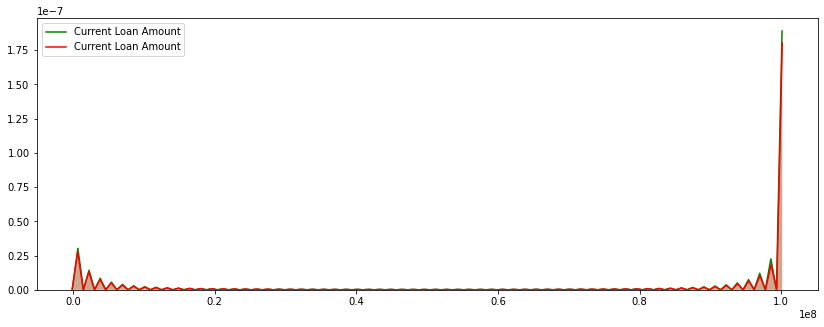

Credit Score


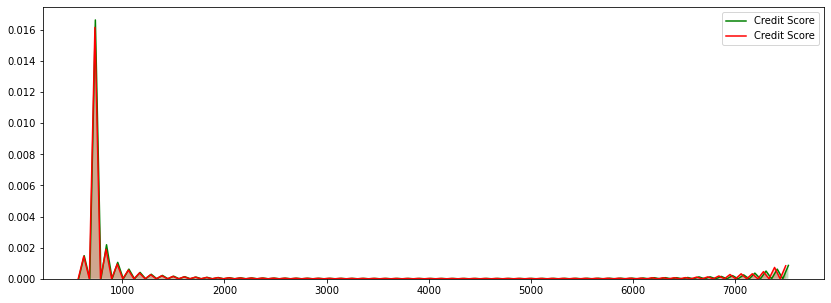

Months since last delinquent


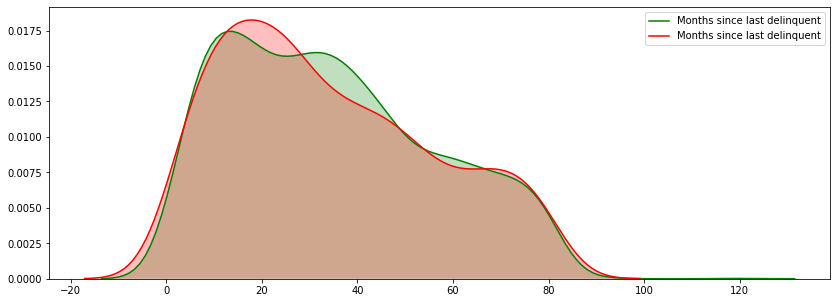

Current Credit Balance


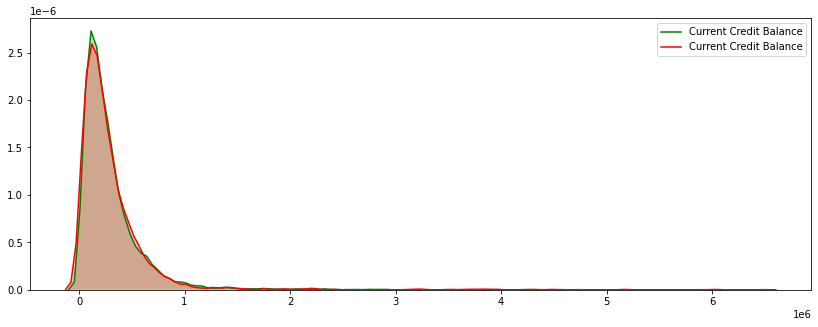

Monthly Debt


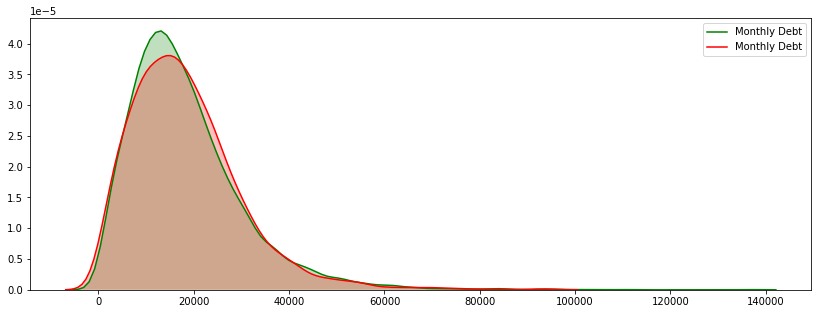

Bankruptcies


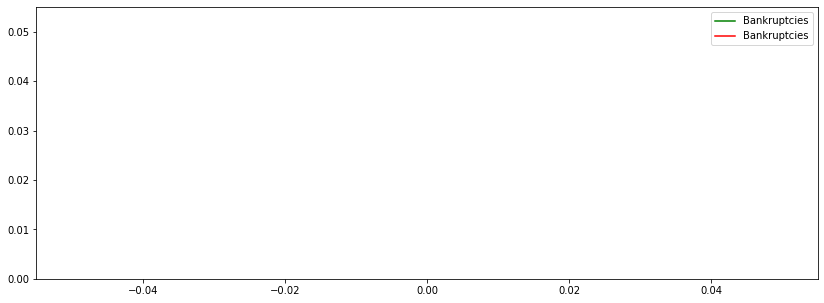

In [5694]:
#Рассмотрим распределение на тренировочном и тестовом датасетах
for col in NUM_FEATURE_NAMES:
    print(col)
    plt.figure(figsize = (14,5))
    sns.kdeplot(df_train[col], shade=True,  color='g')
    sns.kdeplot(df_test[col], shade=True, color='r')
    plt.show()

Можно сделать вывод, что в целом распределение большинства количественных признаков на тренировочном и тестовом наборе данных похоже|

In [5695]:
for num, column in enumerate(df_train[NUM_FEATURE_NAMES]):
    print(str(num) + ' : ' + str(column) + '\n\n' + str(df_train[column].value_counts()) + '\n' + '-' * 100 + '\n')

0 : Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
----------------------------------------------------------------------------------------------------

1 : Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
----------------------------------------------------------------------------------------------------

2 : Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      

### Изучим отдельные признаки подробнее

#### Credit Score - наибольшая корреляция с целевой переменной

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [5696]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [5697]:
df_train['Credit Score'].value_counts().count()

268

In [5698]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [5699]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

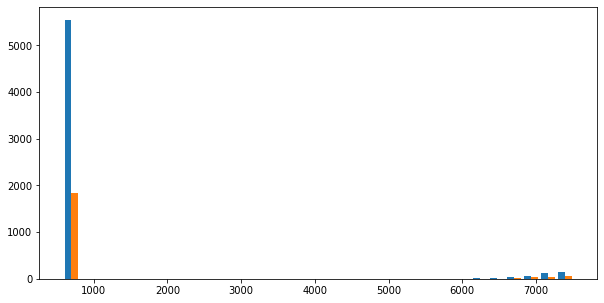

In [5700]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Credit Score'], df_test['Credit Score']], bins = 30)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [5701]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [5702]:
df_train['Credit Score'].min()

585.0

In [5703]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

In [5704]:
df_train['Credit Score'].max()

7510.0

Значений хвоста немного, но их распределение на трейне и тесте похоже, однако я предполагаю, что это может внести неточность в модель. Поэтому выделим отдельным признаком слишком большые значения признака, а также признак-метку, обозначающий пропуски

Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

In [5705]:
df_train['Credit Score'].isnull().sum()

1557

#### Annual Income - Годовой доход

In [5706]:
df_train['Annual Income'].isnull().sum()

1557

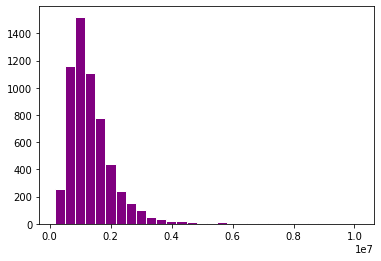

In [5707]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(df_train['Annual Income'], bins = 30, color = 'purple', ec = 'white')

plt.show()

Доход - очень индивидуальный признак, повторяющихся значений очевидно мало, в данном случае все его значения можно допустить и не причислять к выбросам

In [5708]:
#Вариант 1. 
# Добавляем признак о неизвестном доходе и присваиваю всем наблюдениям 0
#df_train['Unknown Income'] = 0
# Всем, у кого неизвестна зарплата делаем пометку "1" в столбец unknown_income
#df_train.loc[(df_train['Annual Income'].isnull()), 'Unknown Income'] = 1

# Вариант 2

#train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median(), inplace = True)



#### Current Loan Amount - Текущий кредитный баланс

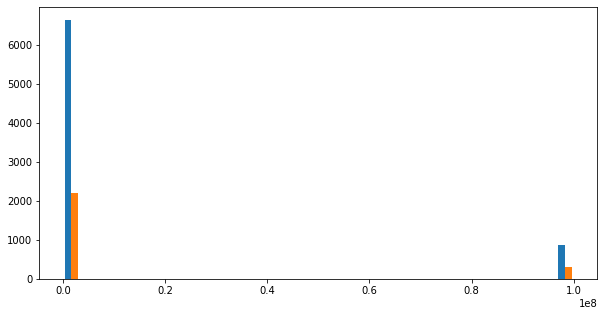

In [5709]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Current Loan Amount'], df_test['Current Loan Amount']], bins = 30)
plt.show()

In [5710]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [5711]:
df_train['Current Loan Amount'].max()

99999999.0

Примем максимальное значение Current Loan Amount за максимальную сумму кредита
В таком случае сделает дополнительные признаки-метки выбросов метку по значениям признака Maximum Open Credit (больше или меньше максимальной суммы кредита) и отдельный признак метку максимального значения  для признака Current Loan Amount , не решаюсь однозначно избавляться от выброса

In [5712]:
df_train['Maximum Open Credit'].max()

1304726170.0

In [5713]:
df_train['Current Loan Amount'].max()

99999999.0

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

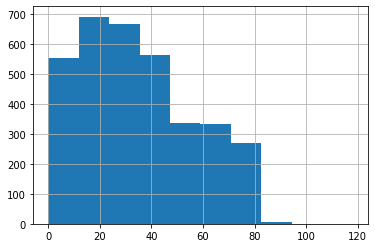

In [5714]:
df_train['Months since last delinquent'].hist()
plt.show()

In [5715]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [5716]:
df_train['Months since last delinquent'].isnull().sum()

4081

**В этом признаке самое большое количество пропусков**

In [5717]:
df_train['Months since last delinquent'].isnull().sum()

4081

In [5718]:
df_train['Months since last delinquent'].min()

0.0

In [5719]:
df_train.loc[df_train['Months since last delinquent'] == 0, 'Months since last delinquent'].count()

18

Предположим, что пропуски в данном случае неслучайны и они обозначают, что просрочки платежа нет. Поэтому заменим. NaN на 0.

В данном случае следует добавить бинарный признак, показывающий наличие или отсутствие задолженности (0 - значение признака 0, 1-значения признака, отличные от 0)

#### Credit Score

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [5720]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [5721]:
df_train['Credit Score'].value_counts().count()

268

In [5722]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [5723]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, допустим, что он может быть большим

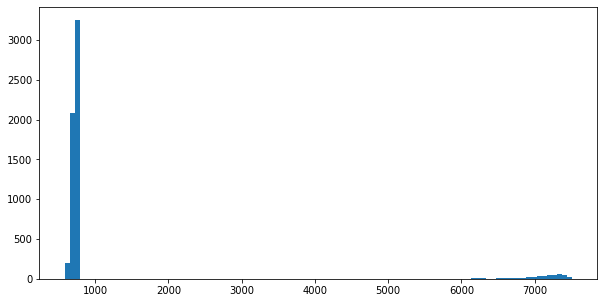

In [5724]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
ax.hist(df_train['Credit Score'], bins = 100)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [5725]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [5726]:
df_train['Credit Score'].min()

585.0

Значений хвоста немного, но я все же считаю его выбросом. Я стараюсь избегать заполнения пропусков каким-то одним значением, и здесь можно предположить деления больших значений на 10, тогда значения равномерно сократятся и будут вписываться в общий массив значений
Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

**Поскольку у признака Credit Score большое количество пропусков и очевидно, что он будет важен для модели, создадим дополнительный признак метку, где обозначим клиентов, у которых не был это показатель известен - unknown_credit_score**

### Категориальные признаки

**Изучим распределение категориальных признаков на тренировочном и тестовом наборах данных в зависимости от разных признаков (num_feature)**

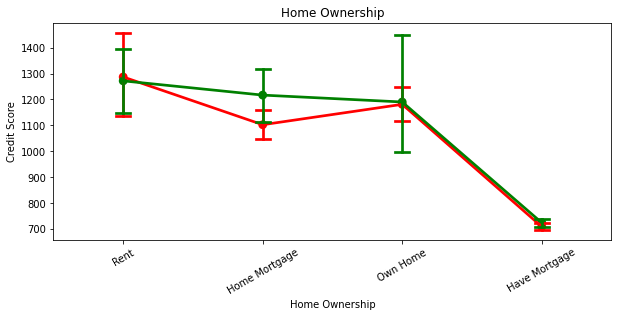

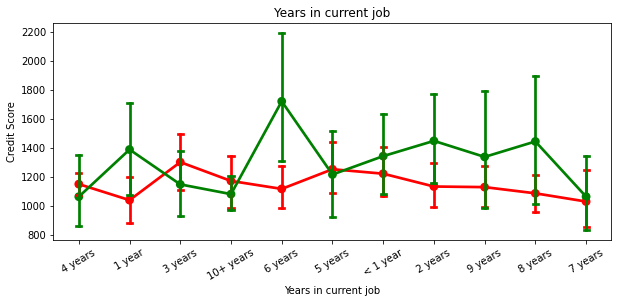

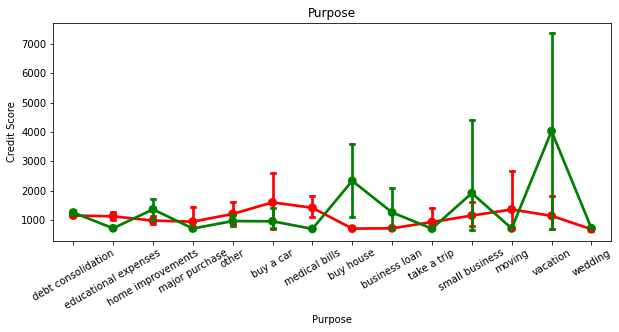

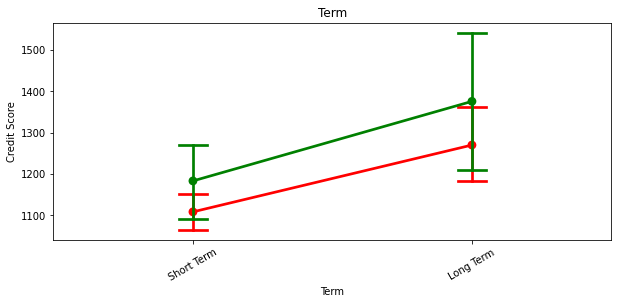

In [5727]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(10,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

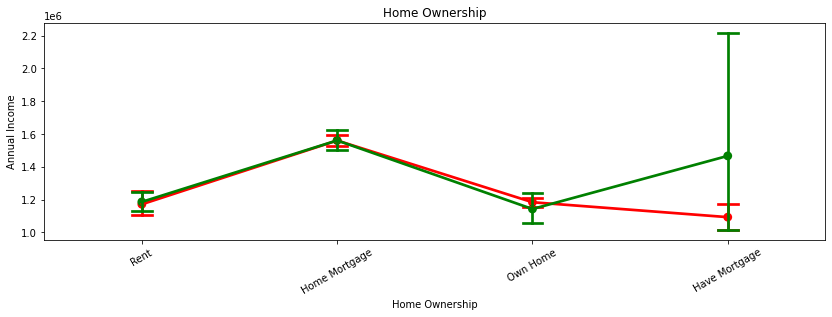

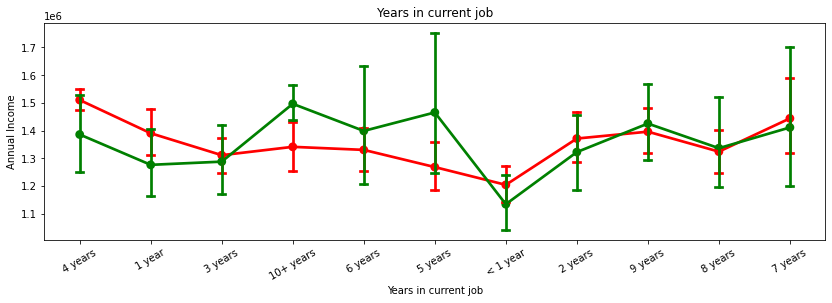

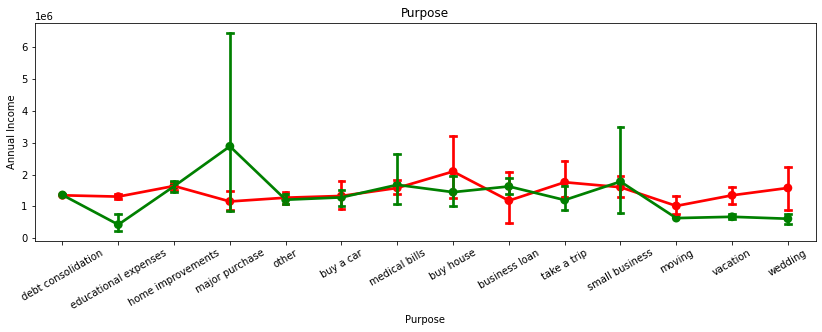

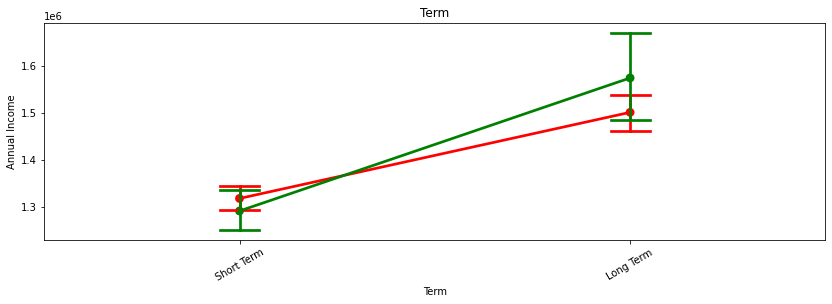

In [5728]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(14,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

#### Years in Current Job

In [5729]:
years_job = df_train['Years in current job'].value_counts()

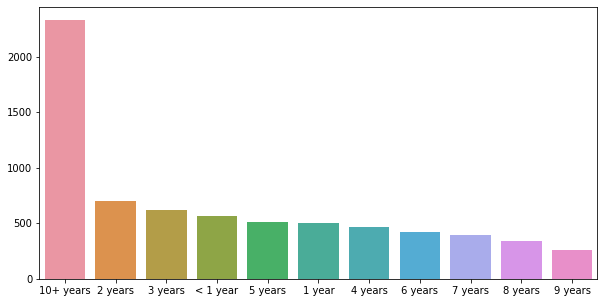

In [5730]:
plt.figure(figsize = (10,5))
sns.barplot(years_job.index, years_job.values)
plt.show()

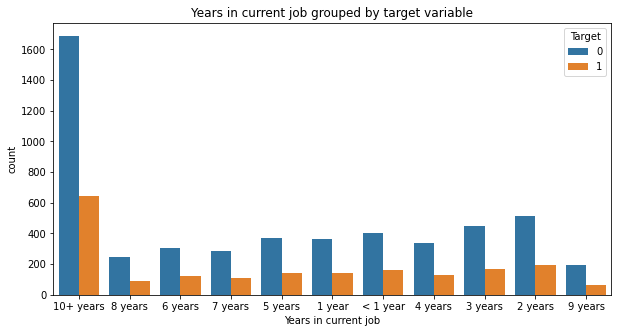

In [5731]:
plt.figure(figsize = (10,5))

sns.countplot(x=df_train["Years in current job"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [5732]:
# Не забудем, что у признака были найдены пропуски
df_train['Years in current job'].isnull().sum()

371

Значений признака относительно много, а пропусков довольно мало, попробуем заполнить их рандомными значениями из имеющихся в признаке.

In [5733]:
list(df_train['Years in current job'].unique())

[nan,
 '10+ years',
 '8 years',
 '6 years',
 '7 years',
 '5 years',
 '1 year',
 '< 1 year',
 '4 years',
 '3 years',
 '2 years',
 '9 years']

In [5734]:
list(df_test['Years in current job'].unique())

['4 years',
 '1 year',
 '3 years',
 '10+ years',
 '6 years',
 '5 years',
 '< 1 year',
 '2 years',
 '9 years',
 '8 years',
 '7 years',
 nan]

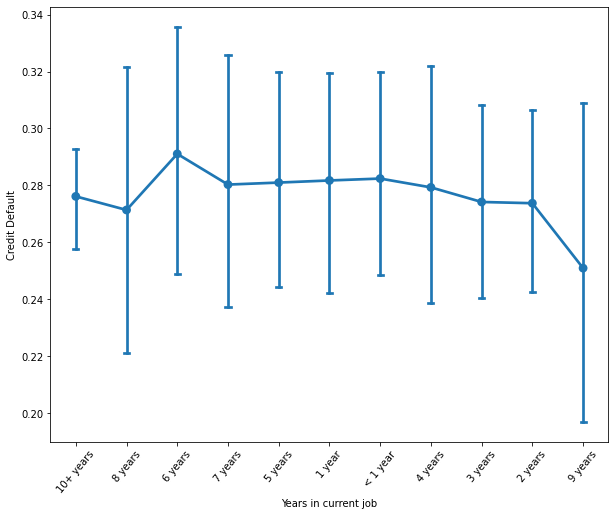

In [5735]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Years in current job', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

Визуально, а также по критерию Хи квадрат, распределение более половины категорий данного признака похожа и можно было бы их объединить,

Однако, во -первых, модель стала хуже, во-вторых, на мой взгляд это тот признак, объединять категории которого с точки зрения логики не стоит

#### Purpose - цель кредита

In [5736]:
purpose_values = df_train['Purpose'].value_counts()

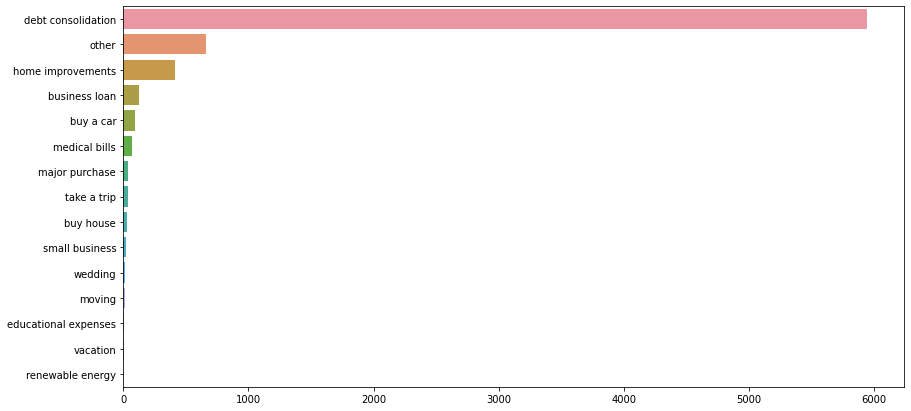

In [5737]:
plt.figure(figsize = (14,7))
sns.barplot(purpose_values.values, purpose_values.index)
plt.show()

In [5738]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'].count()

5944

In [5739]:
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'].count()

2

In [5740]:
df_test.loc[df_test['Purpose']=='renewable energy', 'Purpose'].count()

0

In [5741]:
#однозначно категорию renewable energy убираем
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'] = 'debt consolidation'

In [5742]:
list(df_train['Purpose'].unique())

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'small business',
 'business loan',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation']

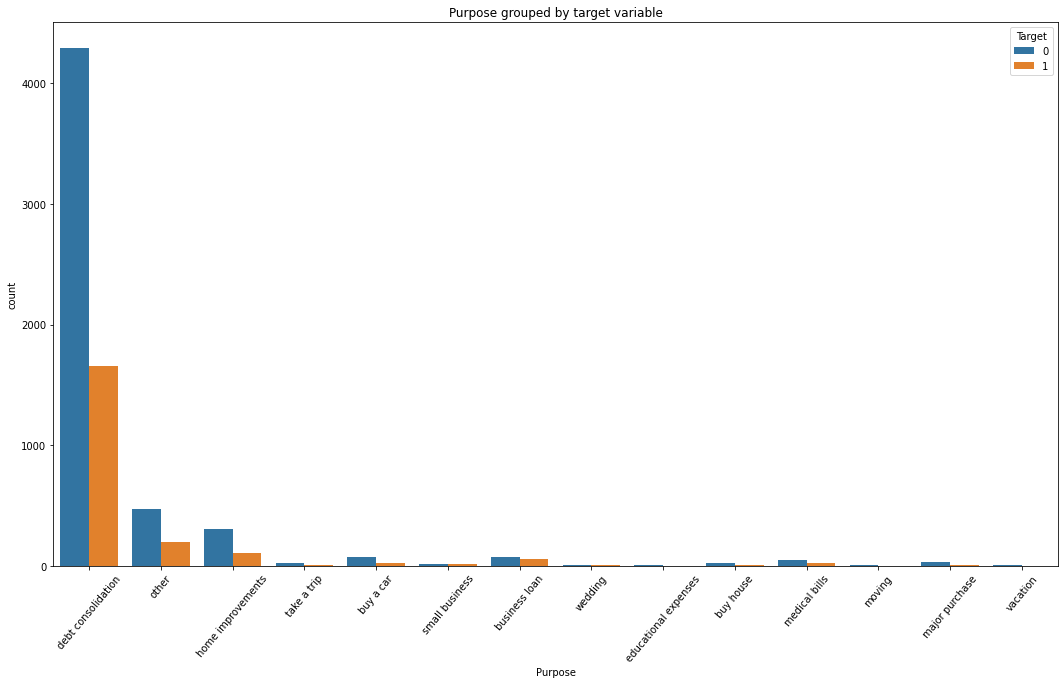

In [5743]:
plt.figure(figsize = (18,10))

sns.countplot(x=df_train["Purpose"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation = 50)

plt.show()

In [5744]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation'], dtype=object)

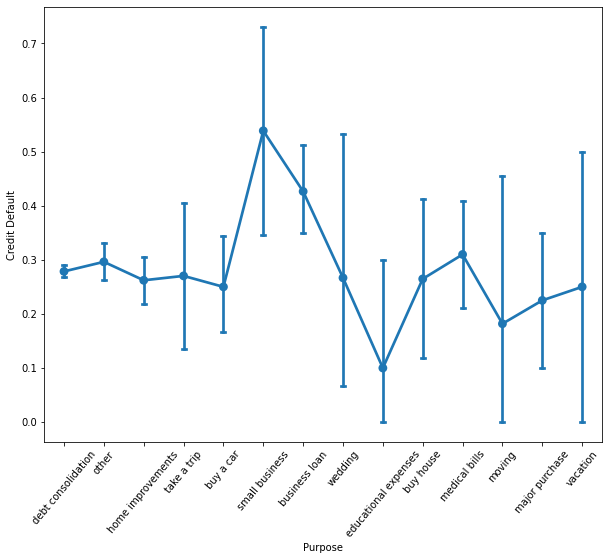

In [5745]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

Визуально, можно объединить следующие группы признаков:
    
* 'business loan', 'small business', 'renewable energy' (признак, которого нет в тесте однозначно надо с кем-то объединить)
* 'medical bills', 'other'
* 'take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation'
* 'educational expenses', 'moving', 'major purchase'

Примем за нулевую гипотезу согласованность частот указанных выше групп категорий и попробуем ее подтвердить либо опровергнуть

Проверим согласованность частот категории с помощью критерии Хи квадрат

In [5746]:
business =  df_train['Purpose'].isin(['business loan', 'small business'])
medical = df_train['Purpose'].isin(['medical bills', 'other'])
personal = df_train['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',
                                     'buy house', 'home improvements', 'buy a car', 'vacation'])
other = df_train['Purpose'].isin(['educational expenses', 'moving', 'major purchase'])

In [5747]:
df_train['Id'] = df_train.index

In [5748]:
purpose_business_and_target = df_train.loc[business, ['Id', 'Purpose', 'Credit Default']]
purpose_medical_and_target = df_train.loc[medical, ['Id', 'Purpose', 'Credit Default']]
purpose_personal_and_target = df_train.loc[personal, ['Id', 'Purpose', 'Credit Default']]
purpose_other_and_target = df_train.loc[other, ['Id', 'Purpose', 'Credit Default']]
table1 = purpose_business_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table2 = purpose_medical_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table3 = purpose_personal_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table4 = purpose_other_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')

In [5749]:
chi2, p, _, _ = chi2_contingency(table1)
p

0.40483403834216214

In [5750]:
chi2, p, _, _ = chi2_contingency(table2)
p

0.918726076937743

In [5751]:
chi2, p, _, _ = chi2_contingency(table3)
p

0.9877062252818661

In [5752]:
chi2, p, _, _ = chi2_contingency(table4)
p

0.6670131614664776

p-value существенно превышает урове значимость 0.05, поэтому принимаем нулевую гипотезу и сократим количество категорий признака Purpose, объединив их в группы

#### Home Ownership   - домовладение         

In [5753]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Предположим, что Have Mortgage - выброс, возникший в результате опечатки и заменим 12 значений на Home Mortgage

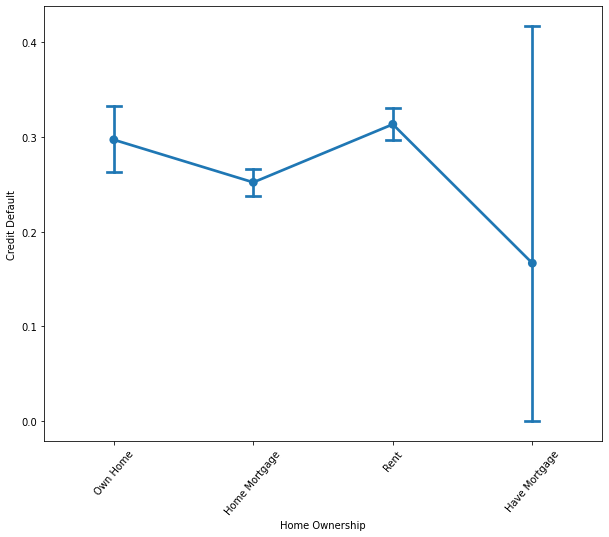

In [5754]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Home Ownership', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

In [5755]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

#### Bankruptcies   - банкротства         

In [5756]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [5757]:
df_train['Bankruptcies'].isnull().sum()

14

Видимо, значение признака предполагает количество банкротств юр. лиц , зарегистрированных на клиента. Т.к. обычно бОльшая часть население не имеет зарегистрированных на себя фирм, то значение 0 преобладает. Однако есть клиенты, кто видимо неоднократно пытался начать свой бизнес и терпел неудачу, количество таких лиц стремительно сокращается. Допускаю, что значения признака адекватны в данном случае.

Пропуски имеет смысл заполнить нулями, пропусков мало и это допустимо

In [5758]:
#на графике выше видно , что значения на трейне и тесте отличаются, изучим подробнее
list(df_train['Bankruptcies'].unique())

[1.0, 0.0, 3.0, nan, 2.0, 4.0]

In [5759]:
list(df_test['Bankruptcies'].unique())

[0.0, 1.0, 5.0, nan, 2.0, 3.0, 4.0]

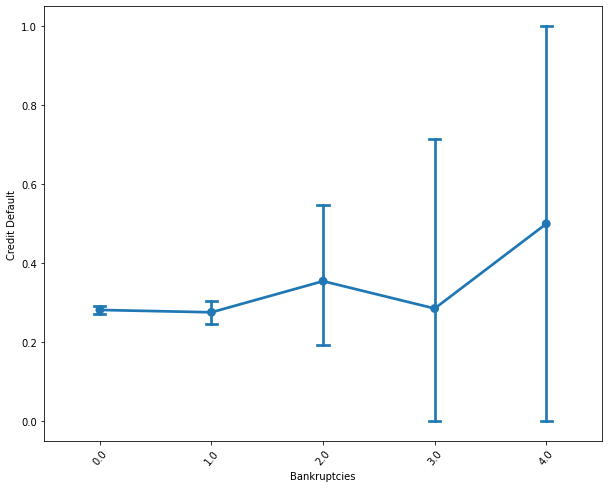

In [5760]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Bankruptcies', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

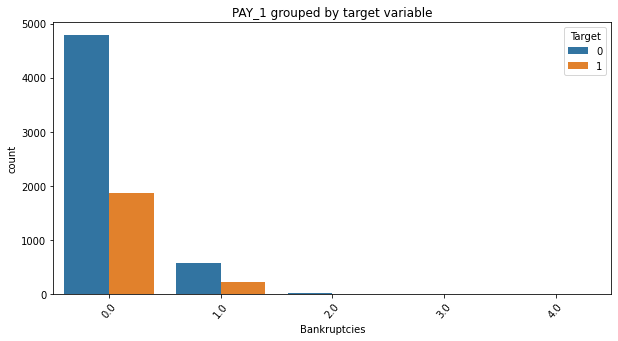

In [5761]:
plt.figure(figsize = (10,5))

sns.countplot(x=df_train["Bankruptcies"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation = 50)

plt.show()

In [5762]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].astype('object')

In [5763]:
#df_train['Bankruptcies'].unique()

In [5764]:
#bankr_and_target = df_train.loc[df_train['Bankruptcies'].isin([1.0, 2.0]), ['Id','Credit Default', 'Bankruptcies']]

In [5765]:
#table= bankr_and_target.pivot_table(values='Id', index='Bankruptcies', columns='Credit Default', aggfunc='count')
#table

In [5766]:
#chi2, p, _, _ = chi2_contingency(table)
#p

Объединение категорий 1 и 0 не показало себя в модели.

In [5767]:
df_train.drop('Id', axis = 1, inplace = True)

### Разбиение на train и test

In [5768]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21, stratify = y)

In [5769]:
X_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies',
       'Months since last delinquent', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership',
       'Years in current job', 'Purpose', 'Term'],
      dtype='object')

In [5770]:
y_train.values

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

 ## Обработка признаков -  Feature Engineering  

**Python код для преобразования данных** -  обрабатываем пропуски, выбросы, формируем итоговые датасеты

In [5771]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.annual_income_median = None
        self.current_loan_am_median = None
        self.credit_score_median = None
        self.max_credit = None
        self.mode_years_in_current_job = None
        self.mean_current_loan_am = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет статистик
        self.annual_income_median = df['Annual Income'].median()
        self.current_loan_am_mean = df.loc[df["Current Loan Amount"] <= 99999999, "Current Loan Amount"].mean()
        self.credit_score_median = df['Credit Score'].median()
        self.max_credit = 99999999.0
        self.mode_years_in_current_job = df['Years in current job'].mode().loc[0]

    def transform(self, df):
        """Трансформация данных"""
        
        # 0. Добавление новых признаков на основе проблемных (пропуски, выбросы)
        
        #отметит отдельно клиентов с неизвестным уровнем дохода
        df['Unknown_annual_income'] = 0
        df.loc[(df['Annual Income'].isnull()), 'Unknown_annual_income'] = 1
        
        #аналогично с неизвестным Credit Score
        df['Unknown_credit_score'] = 0
        df.loc[(df['Credit Score'].isnull()), 'Unknown_credit_score'] = 1
        
        #На графике признака Credit Score были обнаружены сильно отличающиеся в бОльшую сторону значения
        #поскольку однозначно утверждать, что это выброс нельзя, сделаем признак-метку
        
        df['Credit score_outline']=0
        df.loc[df['Credit Score']>1000, 'Credit score_outline']=1 

        
        #Принимая максимальное значение признака Current Loan Amount за максимальную сумму кредита, сделаем метку по
        # значениям признака Maximum Open Credit (больше или меньше максимальной суммы)
        df['Maximum Open Credit Outlier'] = 0
        df.loc[df['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit Outlier'] = 1
        
        #NEWWWW
        df['Current Loan Amount Outlier'] = 0
        df.loc[df['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        
         #3. Корректировка выбросов
            
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] =  df.loc[df['Credit Score'] > 1000, 'Credit Score'] / 10
        
        df.loc[df['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit'] = self.max_credit
        
        df.loc[df["Current Loan Amount"] >= 99999999, "Current Loan Amount"] = self.current_loan_am_mean
        
        # 2. Заполним пропуски
        
        df['Annual Income'].fillna(self.annual_income_median, inplace=True)
        df['Credit Score'].fillna(self.credit_score_median, inplace = True)
        df['Years in current job'].fillna(self.mode_years_in_current_job, inplace=True)
        df['Bankruptcies'].fillna(0 , inplace=True)
        
       
        # 3. Новые фичи (features)
        '''ГЕНЕРАЦИЯ НОВЫХ ПРИЗНАКОВ'''
        
        # 1) Бинарный признак о наличии задолженности на основе признака Months since last delinquent - has_delay

        df['Has_delay'] = 1
        df.loc[(df['Months since last delinquent'] == 0), 'Has_delay'] = 0
        
        
        # 4) Признак-метка клиента с отсутствием проблем с кредитами - no problems
        df['No problems'] = 1
        df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems']\
                                                                                  == 0)
        
        # 5) Добавим новый признак - доля дохода клиента, которая уходит на кредит - part_of_income_for_credit
        
        df['part_of_income_for_credit'] = df['Monthly Debt']*12/df['Annual Income']
        
        # 6) Ежемесянчй доход
        df['Monthly Income'] = df['Annual Income'] / 12
        
        # 7) Разница между ежемес доходом и ежемес выплатой
        df['Monthly Income and Debt Diff'] = df['Monthly Income'] - df['Monthly Debt']
        
        
        # 4. Обработка категорий - Purpose, Years in current job, Bankruptcies, Home Ownership, Term
        
        #Purpose
        
        df.loc[df['Purpose'].isin(['business loan', 'small business', 'renewable energy']), 'Purpose'] = 'business'
        df.loc[df['Purpose'].isin(['medical bills', 'other']), 'Purpose'] = 'medical'
        df.loc[df['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation']), 'Purpose'] = 'personal'
        df.loc[df['Purpose'].isin(['educational expenses', 'moving', 'major purchase']), 'Purpose'] = 'other'

        #Попытка закодировать категории Purpose ухудшили модель
       
        df['Years in current job'] = df['Years in current job'].map({'< 1 year':'0', 
                                                             '1 year':'1', 
                                                             '2 years':'2', 
                                                             '3 years':'3', 
                                                             '4 years':'4', 
                                                             '5 years': '5', 
                                                             '6 years': '6', 
                                                             '7 years': '7', 
                                                             '8 years':'8', 
                                                             '9 years': '9', 
                                                             '10+ years': '10'}).astype(int)
        
        #df.drop('Purpose', axis=1, inplace = True)
         # Переведем уникальные значения в дамми 
        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
        
        
       
        #Term - бинарное кодирование
        df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
        
        # Home Ownership
        
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'],  prefix="Ownership")], axis=1)
        
        df.drop('Months since last delinquent', axis=1, inplace=True)  #признак не приносит пользы при любых вариантах использования
        df.drop('Bankruptcies', axis=1, inplace=True)  #признак не приносит пользы
        df.drop('Home Ownership', axis=1, inplace=True)  #переведен в дамми
        df.drop('Purpose', axis=1, inplace=True)  #переведен в дамми
        
        return df

In [5772]:
pipe = DataPipeline()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

Ниже пробовала пердсказать значения Months since last delinquent, однако признак очень плохо показал себя в модели и пришлось от него отказаться

In [5773]:
'''
def fillna_months_since_last_deliq(df):
    df_1 = df[FEATURES_AFTER_TRANSFORMATION]
    model, df_1 = imputer_rfr(df_1, 'Months since last delinquent')
    df['Months since last delinquent'] = df_1['Months since last delinquent']
    df['Months since last delinquent'] = round(df['Months since last delinquent'])
    return dfX
 '''  

"\ndef fillna_months_since_last_deliq(df):\n    df_1 = df[FEATURES_AFTER_TRANSFORMATION]\n    model, df_1 = imputer_rfr(df_1, 'Months since last delinquent')\n    df['Months since last delinquent'] = df_1['Months since last delinquent']\n    df['Months since last delinquent'] = round(df['Months since last delinquent'])\n    return dfX\n "

In [5774]:
'''
fillna_months_since_last_deliq(X_train)
fillna_months_since_last_deliq(X_test)
fillna_months_since_last_deliq(df_test)
'''

'\nfillna_months_since_last_deliq(X_train)\nfillna_months_since_last_deliq(X_test)\nfillna_months_since_last_deliq(df_test)\n'

In [5775]:
X_train.isnull().sum()

Annual Income                   0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Years in current job            0
Term                            0
Unknown_annual_income           0
Unknown_credit_score            0
Credit score_outline            0
Maximum Open Credit Outlier     0
Current Loan Amount Outlier     0
Has_delay                       0
No problems                     0
part_of_income_for_credit       0
Monthly Income                  0
Monthly Income and Debt Diff    0
Purpose_business                0
Purpose_medical                 0
Purpose_other                   0
Purpose_personal                0
Ownership_Home Mortgage         0
Ownership_Own Home              0
Ownership_Rent                  0
dtype: int64

In [5776]:
X_train.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,part_of_income_for_credit,Monthly Income,Monthly Income and Debt Diff,Purpose_business,Purpose_medical,Purpose_other,Purpose_personal,Ownership_Home Mortgage,Ownership_Own Home,Ownership_Rent
9,1175454.0,0.0,10.0,24.6,511302.0,0.0,5.728800e+05,205333.0,17613.0,731.0,...,0.179808,97954.500000,80341.500000,0,0,0,1,1,0,0
468,2443514.0,0.0,10.0,20.5,83380.0,0.0,1.183652e+07,65892.0,43983.0,694.0,...,0.215999,203626.166667,159643.166667,0,0,0,1,0,0,1
2222,2321040.0,0.0,9.0,18.7,665258.0,1.0,1.183652e+07,406201.0,31334.0,720.0,...,0.162000,193420.000000,162086.000000,0,0,0,1,1,0,0
2611,1175454.0,0.0,8.0,16.9,715330.0,0.0,4.202220e+05,337307.0,30038.0,731.0,...,0.306653,97954.500000,67916.500000,0,0,0,1,1,0,0
1750,1175454.0,0.0,16.0,22.6,6052442.0,0.0,7.876440e+05,867692.0,23698.0,731.0,...,0.241929,97954.500000,74256.500000,0,0,0,1,1,0,0


### Балансировка классов

In [5777]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [5778]:
#Подготовим датасет для балансировки классов

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing = df_for_balancing.drop(columns = df_for_balancing.select_dtypes(include='object').columns)
df_for_balancing.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,Monthly Income,Monthly Income and Debt Diff,Purpose_business,Purpose_medical,Purpose_other,Purpose_personal,Ownership_Home Mortgage,Ownership_Own Home,Ownership_Rent,Credit Default
9,1175454.0,0.0,10.0,24.6,511302.0,0.0,5.728800e+05,205333.0,17613.0,731.0,...,97954.500000,80341.500000,0,0,0,1,1,0,0,1
468,2443514.0,0.0,10.0,20.5,83380.0,0.0,1.183652e+07,65892.0,43983.0,694.0,...,203626.166667,159643.166667,0,0,0,1,0,0,1,0
2222,2321040.0,0.0,9.0,18.7,665258.0,1.0,1.183652e+07,406201.0,31334.0,720.0,...,193420.000000,162086.000000,0,0,0,1,1,0,0,0
2611,1175454.0,0.0,8.0,16.9,715330.0,0.0,4.202220e+05,337307.0,30038.0,731.0,...,97954.500000,67916.500000,0,0,0,1,1,0,0,0
1750,1175454.0,0.0,16.0,22.6,6052442.0,0.0,7.876440e+05,867692.0,23698.0,731.0,...,97954.500000,74256.500000,0,0,0,1,1,0,0,1


In [5779]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3609
1    2832
Name: Credit Default, dtype: int64

**over sampling**: 0 -   3609, 1 -   2832


**under sampling**: 0 -   1416, 1 -   1416


**tomek**: 0 -   3239, 1 -   1455

**smote**: 0 -   3609, 1 -   3609

Выбираем smote 

In [5780]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

При построении разных моделей (были протестированы разные модели с сбалансированными данными и нет) можно сделать однозначный вывод об **улушении результата при сбалансированных данных**. Однако метод **smote** показал себя хуже, чем **over sampling**, вероятно из-за слишком большого искусственного наращивания объектов 1 класса

В моделях с возмжоностью встроенной балансировки разница использования сбалансированных данных и встроенной балансировки не сильная, однако т.к. лучшей моделью я выбрала CatBoost, используем **встроенную балансировку**, используя расчитанный дисбаланс, т.к. она показала себя лучше.

## Построение и оценка моделей. Выбор лучшей

####  Функции для оценки моделей

In [5781]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5782]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5783]:
#Фукнция для изучения важности признаков при построении модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5784]:
#Функция для изучения вероятности принадлежности к № классу

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5785]:
X_train_balanced.shape

(6441, 29)

In [5786]:
df_test.shape

(2500, 29)

In [5787]:
y_train_balanced.value_counts()

0    3609
1    2832
Name: Credit Default, dtype: int64

### Построение лучшей модели

На всякий случай еще раз определим признаки, чтобы ничего не упустить

In [5788]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = ['Annual Income', 
                     'Years in current job', 
                      'Tax Liens',
                      'Number of Open Accounts', 
                      'Years of Credit History',
                      'Maximum Open Credit', 
                      'Number of Credit Problems',
                      'Term',
                      'Current Loan Amount', 
                      'Current Credit Balance', 
                      'Monthly Debt',
                      'Credit Score',
                      ]

NEW_FEATURE_NAMES = ['Unknown_annual_income',
                     'Unknown_credit_score',
                     'Credit score_outline',
                     'Maximum Open Credit Outlier',
                     'Current Loan Amount Outlier',
                     'Has_delay',
                     'No problems',
                     'part_of_income_for_credit',
                     'Monthly Income and Debt Diff',
                     'Monthly Income',
                     'Purpose_business',
                     'Purpose_medical',
                     'Purpose_other',
                     'Purpose_personal',
                     'Ownership_Home Mortgage',
                     'Ownership_Own Home',
                     'Ownership_Rent'
                    ]


In [5789]:
X_train = X_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
X_test = X_test[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
df_test = df_test[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

In [5790]:
df_test.shape

(2500, 29)

### *CATBoost*

In [5791]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                    class_weights=[1,2.55]
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3609
           1       0.77      0.90      0.83      1416

    accuracy                           0.90      5025
   macro avg       0.87      0.90      0.88      5025
weighted avg       0.91      0.90      0.90      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1778
           1       0.49      0.57      0.53       697

    accuracy                           0.71      2475
   macro avg       0.66      0.67      0.66      2475
weighted avg       0.73      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1369  409
1                302  395


#### Настраиваем CatBoost

Я пробовала подавать в Catboost категории без преобразования их в дамми или кодирование (задавая параметров CAT_FEATURE_NAMES = [] - > результат вышел чуть хуже, поэтому идем классическим путем

In [5792]:
disbalance =  y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.5487288135593222

In [5793]:
model_catb = catb.CatBoostClassifier(class_weights=[1, disbalance],
                                    silent = True,
                                    random_state = 21, 
                                    l2_leaf_reg = 10,
                                    eval_metric = 'F1',
                                    early_stopping_rounds = 20,
                                    use_best_model = True,
                                     custom_metric = ['Precision', 'Recall']
                                    )

model_catb.fit(X_train, y_train, plot = True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3609
           1       0.53      0.70      0.61      1416

    accuracy                           0.74      5025
   macro avg       0.70      0.73      0.71      5025
weighted avg       0.77      0.74      0.75      5025

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1778
           1       0.48      0.64      0.55       697

    accuracy                           0.71      2475
   macro avg       0.66      0.69      0.67      2475
weighted avg       0.74      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1300  478
1                249  448


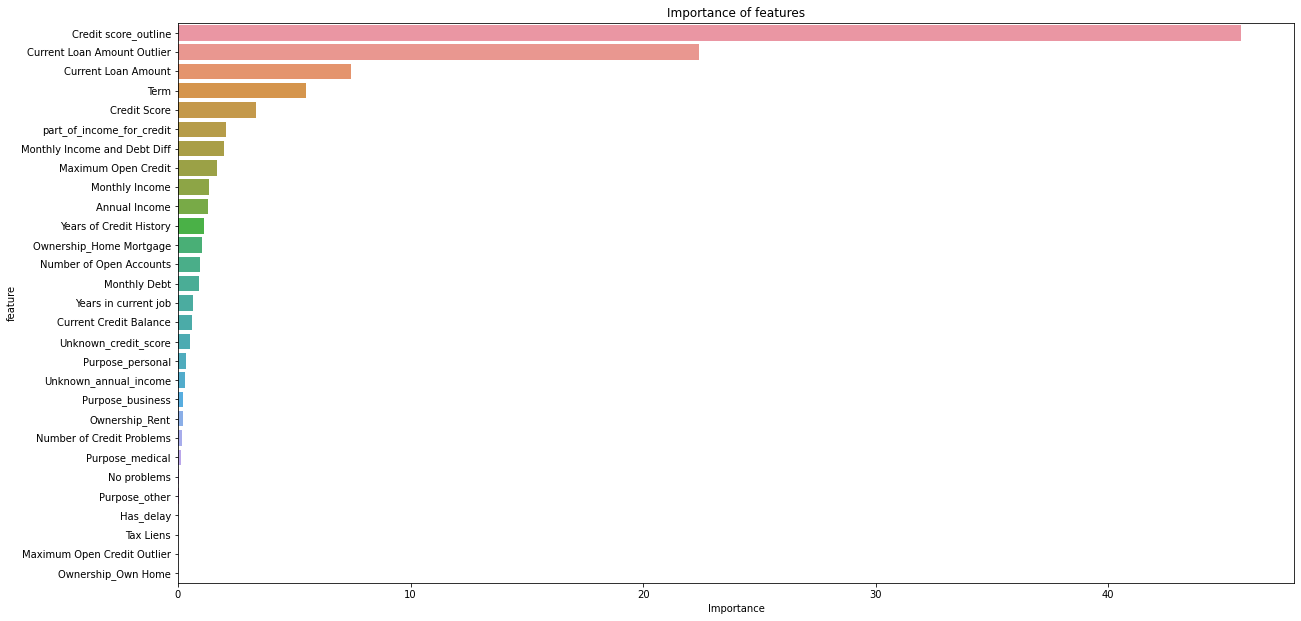

In [5794]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_)

##### Подбор гиперпараметров

In [5795]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'l2_leaf_reg': 10,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

model_catb = catb.CatBoostClassifier(**frozen_params)

In [5796]:
params = {'max_depth' : [3, 4, 5, 6, 7],
           'n_estimators' : [50, 100, 200, 500, 700],
           'min_data_in_leaf': [3, 5, 7, 9]}

In [5797]:
cv= KFold(n_splits=3, random_state=21, shuffle=True)

In [5798]:
rs = RandomizedSearchCV(model_catb, params, scoring = 'f1', cv=cv, n_jobs = -1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D434C111C0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'min_data_in_leaf': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 500,
                                                         700]},
                   scoring='f1')

In [5799]:
rs.best_params_

{'n_estimators': 200, 'min_data_in_leaf': 5, 'max_depth': 5}

In [5800]:
model_catb_params = catb.CatBoostClassifier(**frozen_params, 
                                            n_estimators=200,
                                            #learning_rate=0.03,
                                            min_data_in_leaf = 5,
                                            max_depth=5)

In [5801]:
model_catb_params.fit(X_train, y_train, plot=True, eval_set = (X_test, y_test))

evaluate_preds(model_catb_params, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      3609
           1       0.52      0.67      0.59      1416

    accuracy                           0.73      5025
   macro avg       0.69      0.71      0.70      5025
weighted avg       0.76      0.73      0.74      5025

TEST

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      1778
           1       0.48      0.63      0.55       697

    accuracy                           0.71      2475
   macro avg       0.66      0.68      0.67      2475
weighted avg       0.74      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1311  467
1                258  439


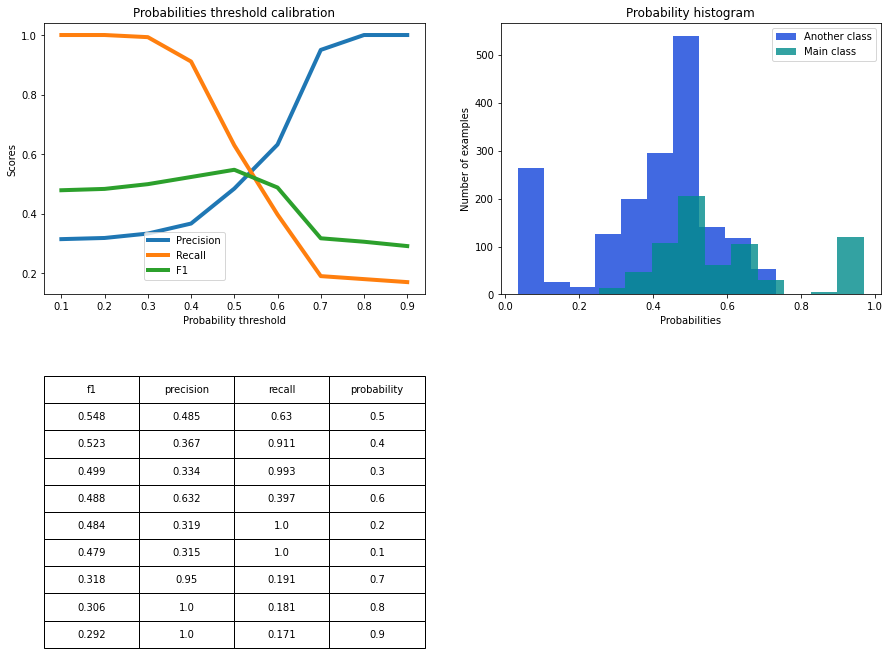

In [5802]:
y_test_pred_probs = model_catb_params.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [5803]:
# Определим финальную модель - final_model
final_model= model_catb_params


### Предсказание на тестовом датасете

In [5804]:
df_test.shape

(2500, 29)

In [5805]:
predictions = final_model.predict(df_test)

In [5806]:
submit = pd.read_csv('sample_submission.csv')

In [5807]:
submit.columns
submit['Credit Default'].head()

0    1
1    1
2    1
3    1
4    1
Name: Credit Default, dtype: int64

In [5808]:
submit['Credit Default'] = predictions

In [5809]:
submit[['Id', 'Credit Default']].to_csv('ALeksandrinaVia_predictions.csv', index=None)

In [5810]:
submit['Credit Default'].head(10) #проверка, что все верно

0    0
1    1
2    1
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: Credit Default, dtype: int64